In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('PRM_L2.csv')
data.dropna()

def b365_odds_to_probability(odds):
    
    probability = 1 / odds if odds > 1 else 1 - odds
    return probability

leagues = data['Level'].unique()
print(leagues)


['PRM' 'CHA' 'L1' 'L2']


In [173]:
groupedreferees = dane.groupby('Referee')
referees = {name: referee for name, referee in groupedreferees if len(referee) > 0}

for i, referee in enumerate(referees):
    referees[referee]['B365H_prob'] = referees[referee]['B365H'].apply(b365_odds_to_probability)
    referees[referee]['B365D_prob'] = referees[referee]['B365D'].apply(b365_odds_to_probability)
    referees[referee]['B365A_prob'] = referees[referee]['B365A'].apply(b365_odds_to_probability)

referees_corr = pd.DataFrame()
league_referees_corr = {}
for league in leagues:
    league_referees_corr[league] = pd.DataFrame(index=referees.keys(), columns=['matches', 'home_corr', 'draw_corr', 'away_corr', 'mean_corr'])

# calculate correlation between actual wins and win  where referees are indexes and columns are home_corr, draw_corr and away_corr
for league in leagues:
    for i, referee in enumerate(referees):
        league_referees_corr[league].loc[referee, 'matches'] = len(referees[referee][referees[referee]['Level'] == league])
        league_referees_corr[league].loc[referee, 'home_corr'] = referees[referee][referees[referee]['Level'] == league]['B365H_prob'].corr(referees[referee][referees[referee]['Level'] == league]['FTR'] == 'H')
        league_referees_corr[league].loc[referee, 'draw_corr'] = referees[referee][referees[referee]['Level'] == league]['B365D_prob'].corr(referees[referee][referees[referee]['Level'] == league]['FTR'] == 'D')
        league_referees_corr[league].loc[referee, 'away_corr'] = referees[referee][referees[referee]['Level'] == league]['B365A_prob'].corr(referees[referee][referees[referee]['Level'] == league]['FTR'] == 'A')
    league_referees_corr[league]['mean_corr'] = league_referees_corr[league][['home_corr', 'draw_corr', 'away_corr']].mean(axis=1)
    league_referees_corr[league].sort_values(by='mean_corr', inplace=True, ascending=False)
for league in leagues:
    league_referees_corr[league].dropna(inplace=True)
    league_referees_corr[league].to_csv('referees_corr_{}.csv'.format(league))

# plot correlation between actual wins and win probability for each referee
# for league in leagues:
#     plt.figure(figsize=(20, 10))
#     plt.title('Correlation between actual wins and win probability for each referee in {}'.format(league))
#     plt.xlabel('Referee')
#     plt.ylabel('Correlation')
#     plt.bar(league_referees_corr[league].index, league_referees_corr[league]['mean_corr'])
#     plt.xticks(rotation=60)
#     plt.show()
league_referees_corr['PRM']

,matches,home_corr,draw_corr,away_corr,mean_corr
D Bond,4,0.457279,0.333333,0.708269,0.499627
R Jones,48,0.614984,0.216156,0.555845,0.462329
J Moss,74,0.490708,0.293222,0.462896,0.415609
C Kavanagh,79,0.505907,0.180513,0.517237,0.401219
A Marriner,81,0.485918,0.190973,0.478048,0.38498
M Atkinson,84,0.46774,0.234153,0.449616,0.383836
P Tierney,103,0.449415,0.091827,0.502199,0.347814
L Mason,27,0.370842,0.166765,0.489544,0.342384
D Coote,78,0.420789,0.10925,0.429413,0.319817
A Taylor,118,0.471426,0.173504,0.311983,0.318971


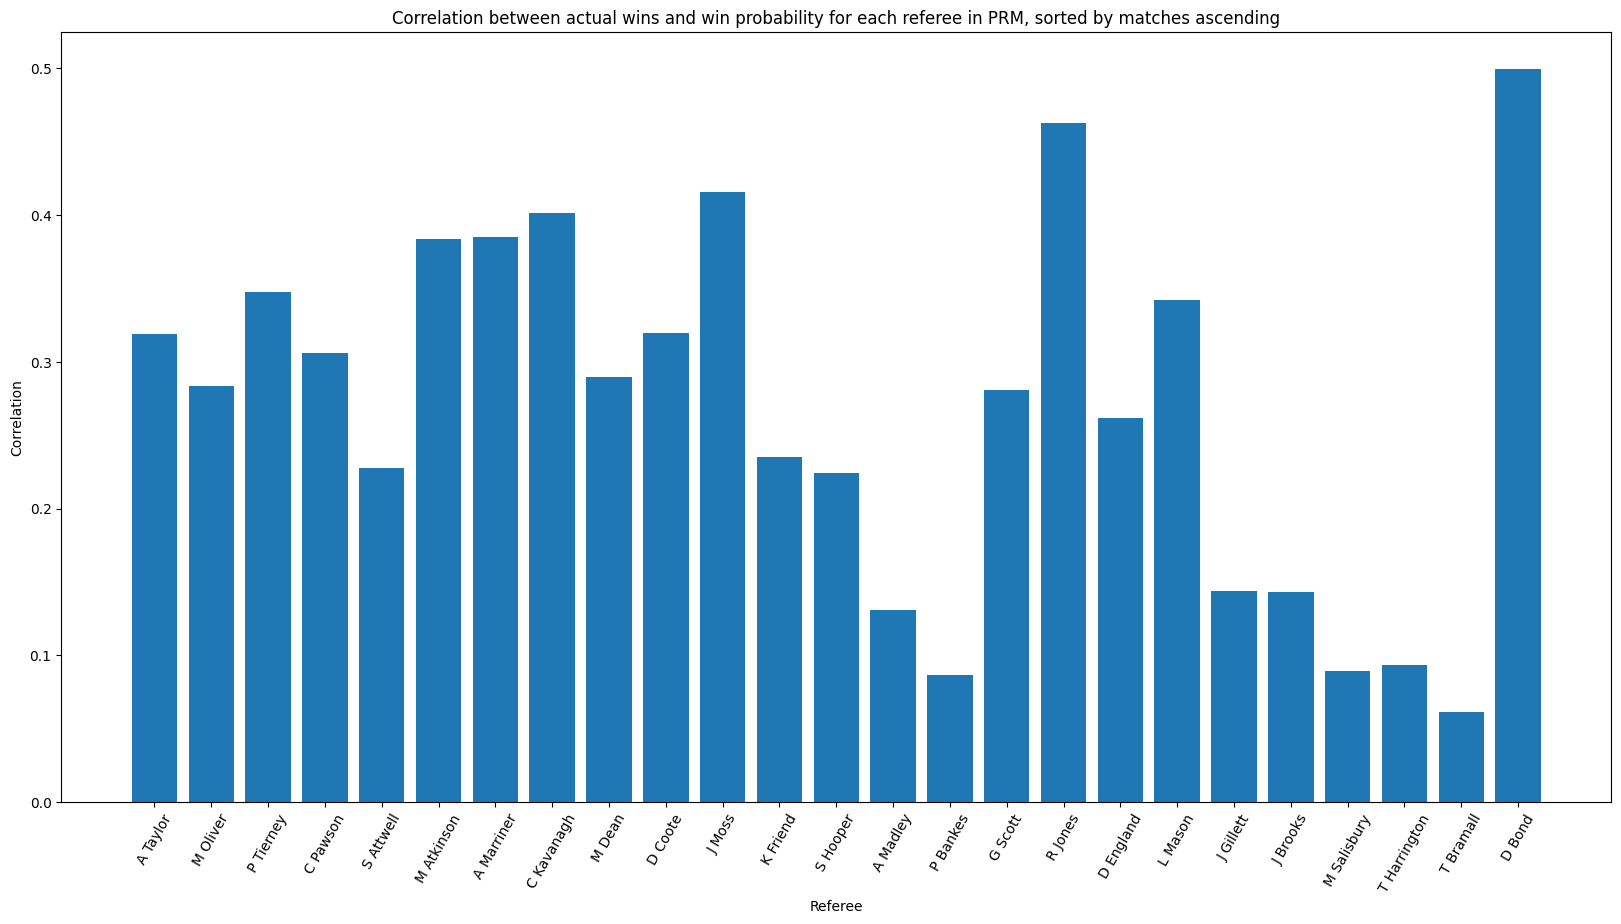

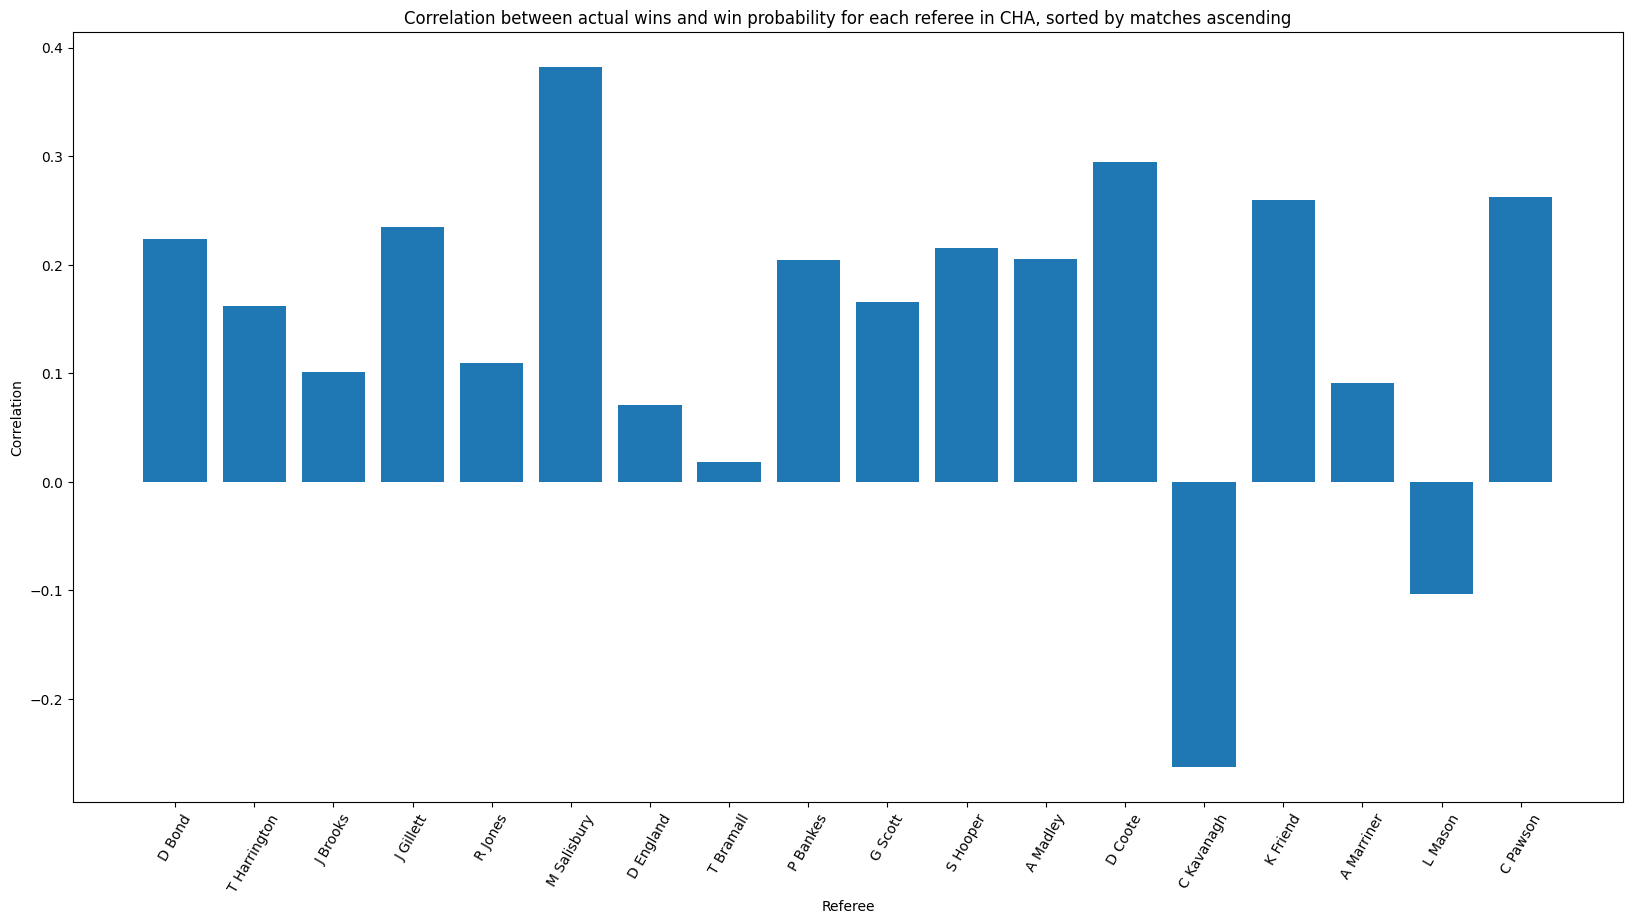

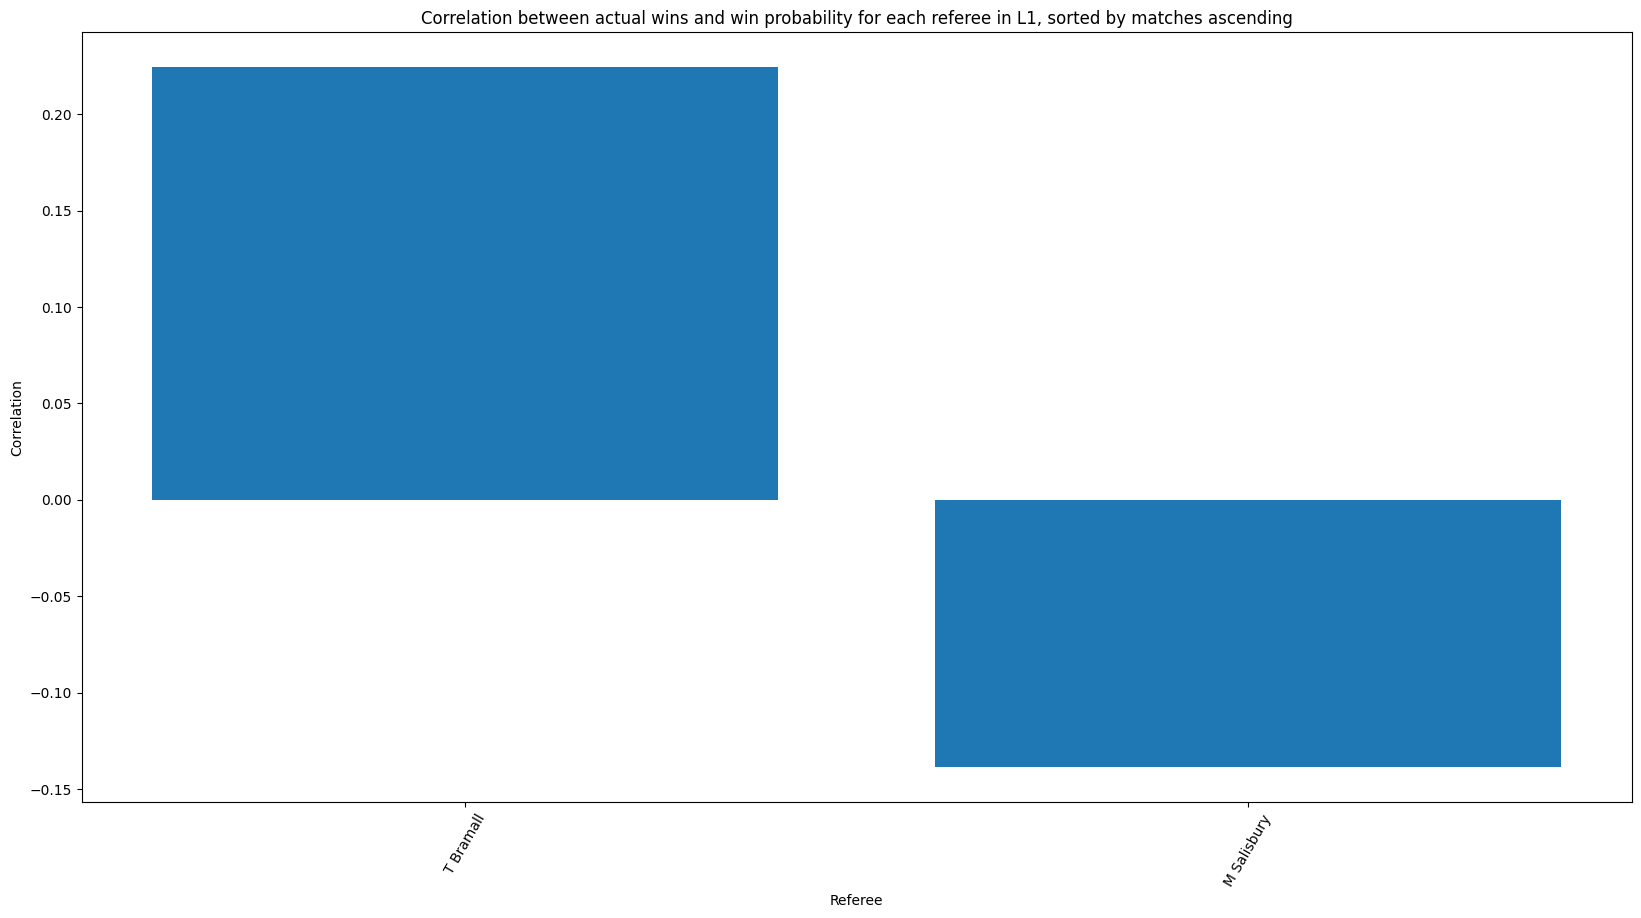

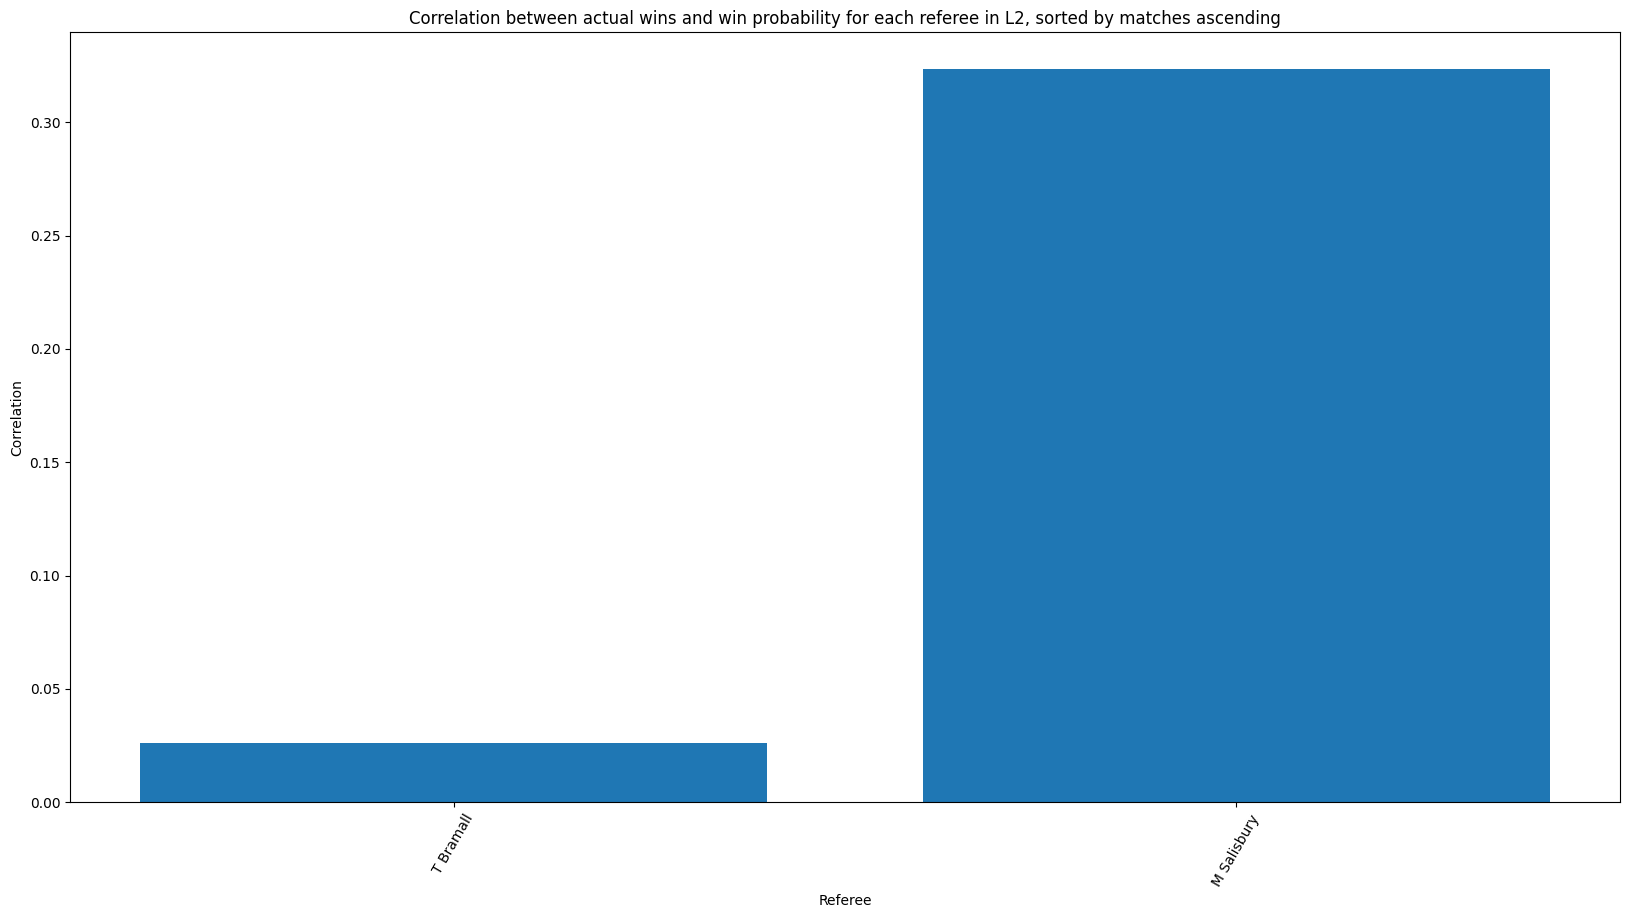

In [174]:
PRM_referees = league_referees_corr['PRM'].index
for league in leagues:
    league_referees_corr[league] = league_referees_corr[league].loc[league_referees_corr[league].index.intersection(PRM_referees)]
    league_referees_corr[league].sort_values(by='matches', inplace=True, ascending=False)

# plot correlation between actual wins and win probability for each referee
for league in leagues:
    plt.figure(figsize=(20, 10))
    plt.title('Correlation between actual wins and win probability for each referee in {}, sorted by matches ascending'.format(league))
    plt.xlabel('Referee')
    plt.ylabel('Correlation')
    plt.bar(league_referees_corr[league].index, league_referees_corr[league]['mean_corr'])
    plt.xticks(rotation=60)
    plt.show()